# PA3 - Word Embeddings

### Introduction

In this notebook, you will learn how to train your own word embeddings using two approaches, then explore some of the fun things you can do with them.

Word Embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

For reference and additional details, please go through Chapter 6 of [the SLP3 book](https://web.stanford.edu/~jurafsky/slp3) and this [nice writeup by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/).

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

## Part 1 - Implementing `word2vec` [80 points]

In this part, you will implement the `word2vec` algorithm. 

While `word2vec` is more of a _framework_ for learning word embeddings, we will focus on the `SkipGram` model, specifically how it was trained in the original 2013 paper. Your primary references for understanding this algorithm will be the lecture slides, and the two aforementioned links.

You will be working with the *greatest* work of literature ever written: ~~the Bee Movie script~~ **The Lord of the Rings** - specifically the first book, *The Fellowship of the Ring*. 

While this book is a masterpiece, it can take a while to train embeddings on the entire text. So, we will be working with a subset of the text. 

In [117]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these

import os
import re
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

### Preparing our raw data

In the cell below, you will read in the data as one very long string.

This will be followed by creating a `Dataset` class that will be helpful in working with your dataset when training the model. The `Dataset` class should have the following attributes/methods:

- `__init__(self, data)` - the constructor that takes in the data and initializes the necessary attributes.

- `data` - the data that is passed in. You can apply a very simple preprocessing pipeline: (1) substitute all punctuation with a period (i.e. `.`), (2) lowercase all the text, and (3) extract only those characters that are alphabetic or a period.

- `tokens` - a list of all the tokens in the data. It might be helpful to use the `nltk.word_tokenize` function already imported for you.

- `vocab` - a set of all the unique tokens in the data. Be sure to sort this and convert it to a list as to have a consistent ordering.

- `vocab_size` - the length of the vocabulary.

- `stoi` - a mapping from the word (s) to their index (i) in the vocab. It is important to have sorted your vocab before creating this mapping.

- `itos` - a mapping from the index (i) to the word (s) in the vocab.

The two mappings will be helpful in fetching your Embeddings later on, since your Embeddings will be a matrix of shape `(vocab_size, embedding_dim)` and the ordering will be dependent on your vocabulary's ordering.

In [118]:
# Read in the data
with open("./The Fellowship of the Ring.txt") as f:
    data = f.read()

print(data[:200]) # print out the first 200 chars
len(data)

J. R. R. Tolkien Â— The Lord Of The Rings. (1/4)
-----------------------------------------------


     THE LORD OF THE RINGS

              by

     J. R. R. TOLKIEN



 Part 1: The Fellowship of the


1025058

In [119]:

import string
class Dataset:

    def __init__(self, data: str):
        self.data = self.preprocess(data)
        self.tokens = word_tokenize(self.data)
        self.vocab = sorted(set(self.tokens))
        self.vocab_size = len(self.vocab)
        
        
        self.stoi = {word: index for index, word in enumerate(self.vocab)}
        self.itos = {index: word for index, word in enumerate(self.vocab)}

     
    def __len__(self):
        return len(self.tokens)
    def replace_punctuation(self,char):
        if char in string.punctuation:
            return ' ' + '.' + ' '
        else:
            return char
    def preprocess(self,data):
        # translator = str.maketrans(string.punctuation, ' ' + '.' * len(string.punctuation))
        # data = data.translate(translator)
        data = ''.join(map(self.replace_punctuation, data))
        data = data.lower()
        # data = ''.join(filter(lambda x: x.isalpha() or x == '.', data))
        return data
  
dataset = Dataset(data)
print(f"Number of tokens in dataset: {len(dataset)}")


Number of tokens in dataset: 229713


In [120]:
# Assuming your dictionary is named 'my_dict'
keys_starting_with_m = [key for key in dataset.stoi.keys() if key.startswith('m')]
print(dataset.stoi)

dataset.stoi['mordor']

{'.': 0, '1': 1, '10': 2, '102': 3, '1070': 4, '11': 5, '111': 6, '1147': 7, '1158': 8, '12': 9, '130': 10, '1311': 11, '1341': 12, '1342': 13, '1401': 14, '1403': 15, '1418': 16, '1420': 17, '1462': 18, '1592': 19, '172': 20, '1914': 21, '1918': 22, '1936': 23, '1937': 24, '1939': 25, '1941': 26, '1944': 27, '1949': 28, '2': 29, '20th': 30, '22nd': 31, '3': 32, '33': 33, '37': 34, '4': 35, '5': 36, '6': 37, '60': 38, '64': 39, '7': 40, '8': 41, '9': 42, 'a': 43, 'abandon': 44, 'abandoned': 45, 'abandons': 46, 'abashed': 47, 'abbreviated': 48, 'abide': 49, 'able': 50, 'aboard': 51, 'abode': 52, 'abominable': 53, 'about': 54, 'above': 55, 'abreast': 56, 'abroad': 57, 'absence': 58, 'absorbed': 59, 'abstracts': 60, 'absurd': 61, 'absurdly': 62, 'abundant': 63, 'abundantly': 64, 'abyss': 65, 'accepted': 66, 'accepting': 67, 'accessory': 68, 'accident': 69, 'accomplish': 70, 'accomplished': 71, 'accord': 72, 'accorded': 73, 'according': 74, 'account': 75, 'accounted': 76, 'accounting': 77,

4810

### Creating our dataset

Now for the fun part of the dataset preparation: creating the windows!

<center>
<img src="https://jalammar.github.io/images/word2vec/skipgram-sliding-window-5.png">
</center>

Recall in class you learned about sliding a window over the text to create the `(context, target)` pairs. You will implement this in the function below. 

We will adopt the following convention: the target word is at the center of a window, and the context words are the words surrounding the target word, with `ctx_size` tokens on either side.

You will implement this to work with a list of tokens (whether that be in string-form, or as indices). The function should return a list of tuples, where each tuple is a pair of the form `(context, target)`.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>The `range` function will return you an iterator where you can specify the start and final indices, as well as the jumps in between. Use this in constructing your for loop.</li>
    <li>One easy way to do this is to begin the loop at the position corresponding to the first center word, then to grab the words to the left and the right in one list. After doing this, your loop moves to the next iter. Be careful with the starting and end iteration variables for your loop.</li>
</ul>
</p>

In [121]:
# Create the dataset using the sliding window approach
def get_windows(
        data: List[Union[str, int]], 
        ctx_size: int
        ):
    '''
    Generates the windows to be used later for dataset creation

    Takes in a list of tokens (as strings or integers/indices) and a context size
    This will slide a window of size 2*ctx_size + 1 over the data producing
    the a list of center words, and the corresponding context words

    Note that ctx_size is the number of context words on EITHER side of the center word
    e.g.
    > get_windows(["I", "love", "my", "dog", "!"], 2) produces the first (and only) window to be
    (["I", "love", "dog", "!"], "my")
    '''
    
    outside_words = []
    center_words = []

    for i in range(len(data)):
        middle_word = data[i]
        context_words = []
        for j in range(i - ctx_size, i + ctx_size + 1):
            if j != i and 0 <= j < len(data):
                context_words.append(data[j])
        if context_words:
            if len(context_words) == 2 * ctx_size:
                outside_words.append(context_words)
                center_words.append(middle_word)
                

    return outside_words, center_words

owords, cwords = get_windows(
    word_tokenize("hello how are you. i am under the water. please help me."),
    2
)

for i in range(len(owords)):
    print(f"{owords[i]} ---> {cwords[i]}")
    


assert owords[1] == ['how', 'are', '.', 'i'] and cwords[1] == 'you' and len(owords) == 11, \
    "Test failed"

['hello', 'how', 'you', '.'] ---> are
['how', 'are', '.', 'i'] ---> you
['are', 'you', 'i', 'am'] ---> .
['you', '.', 'am', 'under'] ---> i
['.', 'i', 'under', 'the'] ---> am
['i', 'am', 'the', 'water'] ---> under
['am', 'under', 'water', '.'] ---> the
['under', 'the', '.', 'please'] ---> water
['the', 'water', 'please', 'help'] ---> .
['water', '.', 'help', 'me'] ---> please
['.', 'please', 'me', '.'] ---> help


Before we move on to creating our model, recall that a key component of the algorithm was **Negative Sampling** so that our model was able to see occurences of words that _didn't_ appear in the context. We will implement this in the next part.

Your `sample_neg_word` is a utility function that will continue sampling a word from the specific vocabulary until it is not the word you have specified. 

When actually implementing the negative sampling, you will sample tokens that are _not_ the center word only - many implementations ignore the exclusion of the context words, so we will do this same simplification here.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use the `np.random.choice` function to sample an element from a list.</li>
    <li>You can think about running a loop where you keep sampling until you have something that isn't the word to exclude. This is the only check you must make.</li>
</ul>
</p>

In [122]:
# To create the dataset, we need to get positive and negative samples according to the windows made
import random
def sample_neg_word(to_exclude: str,
                    vocab: List[str]):
        '''
        Samples a negative word from the vocab, excluding the word to_exclude
        '''
        sample_word = ""
        while((sample_word == to_exclude) or (sample_word == "")):
            index = random.randint(0, len(vocab)-1)
            sample_word = vocab[index]
           
        ## --

        return sample_word

       

### Implementing the actual model

Now you will make use of the `Dataset` class and the `sample_neg_word` function to implement the `SkipGram` model.

Recall the steps of the model:

1. Randomly initialize two matrices: `W` and `C` of shape `(vocab_size, embedding_dim)`. These will be your center/target word and context embeddings respectively.

2. Being looping through each `(context, target)` pair in your dataset.

    2.1. For each pair, sample `K` negative words from the vocabulary.

    2.2. Compute the loss for the context and target word, as well as the negative samples.

    2.3. Compute the gradients for the context and target word, as well as the `K` negative samples.

    2.4. For each of these computed gradients, update the corresponding embeddings.

3. Repeat this process for `num_epochs`.


Recall the formulas for the Loss function and the gradients:

$$L_{CE} = -\log \sigma(c_{pos} \cdot w) - \sum_{i=1}^{K} \log \sigma(-c_{neg_i} \cdot w)$$

$$\frac{\partial L_{CE}}{\partial w} = [\sigma(c_{pos} \cdot w) - 1]c_{pos} + \sum_{i=1}^{K} [\sigma(c_{neg_i} \cdot w)]c_{neg_i}$$

$$\frac{\partial L_{CE}}{\partial c_{pos}} = [\sigma(c_{pos} \cdot w) - 1]w$$

$$\frac{\partial L_{CE}}{\partial c_{neg_i}} = \sigma(c_{neg_i} \cdot w)w$$

Where $c_{pos}$ is the context word, $w$ is the target word, and $c_{neg_i}$ is the $i^{th}$ negative sample.

#### Implementation notes

- You will be implementing all of this in the `word2vec` class, inside the `fit` function. Your embedding matrices will be initialized in the `__init__` function, according to the arguments passed in.

- You **must** print out your loss after every epoch (i.e. after every pass through the dataset). If you have implemented everything perfectly, you should see the loss decreasing over time, with no numerical overflows/underflows or the like.

- Your `fit` function will return the list of losses over each epoch - this will be used to visualize the training process.

- <font size="3" color="red"><b>Do not tamper with code you haven't been permitted to modify.</b></font>

In [123]:
# Create the data
# The dataset is very large, so we will only use the first 2000 tokens for now
# There will be 3 words on each side of the center word
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>A simple (but slightly inefficient) way to implement this would be to use two `for` loops (ignoring the one for sampling the negative words): one for the center word/window, an inner one for each context word so you have a (ctx, target) pair. This is done since you are passing the windows as they are into the function.</li>
    <li>Be VERY careful about which variable is a string, and which is the corresponding index in the vocab. You can use the `encode` function to move from string to index.</li>
    <li>Print out the shapes or use `assert` statements to ensure the shapes are the way you'd expect them. Broadcasting can mess things up if you're not careful.</li>
    <li>Never forget: the gradients that are being calculated will ONLY update the embeddings for the corresponding tokens in the matrices, NOT THE ENTIRE MATRIX.</li>
    <li>An easy way to do this is to make a matrix of zeros representing the gradients for one of the Embedding matrices. When you create the gradient vector(s) for the target/context/negative samples, you can simply replace the corresponding row in that zeros matrix with that vector. The update equation will be very easy to implement.</li>
    <li>If you're running into overflows/underflows or numerical instability, there is something wrong with your implementation. If you're sure everything is correct, double-check your equations with the lecture slides - one wrong sign for a gradient cost me an hour of debugging ;-;</li>
</ul>
</p>

In [124]:
def sigmoid(x : np.ndarray):
    return 1 / (1 + np.exp(-x))

class word2vec:

    def __init__(self, 
                 vocab_size : int, 
                 stoi : dict, 
                 emb_dim : int):

        ## Your code here
        self.W = np.random.rand(vocab_size, emb_dim)
        self.C = np.random.rand(vocab_size, emb_dim)
        self.vocab_size = vocab_size
        self.stoi = stoi
        self.emb_dim = emb_dim
        ## --

    def __call__(self, x : int):
        return (self.W[x] + self.C[x]) / 2
    
    
    def encode(self, x : Union[str, List[str]]):
        return [dataset.stoi[i] for i in x] if isinstance(x, list) else self.stoi[x]

    def fit(self, 
            context_words : List[List[str]], 
            target_words : List[str], 
            num_epochs : int = 5, 
            learning_rate : float = 0.001, 
            K : int = 5):
        '''
        Runs the training algorithm for the word2vec model
        '''
 
        losses = []

        for epoch in range(num_epochs):

            epoch_loss = 0.0

            ## Your code here
            
            for i, target_word in enumerate(target_words):
                outside_words = context_words[i]
                target_index = self.stoi[target_word]

                # Negative sampling and gradient calculation
                neg_words = [sample_neg_word(target_word, list(self.stoi.keys())) for _ in range(K)]
                neg_indices = [self.stoi[neg_word] for neg_word in neg_words]
                neg_gradients = [sigmoid(np.dot(self.W[target_index], self.C[neg_index])) * self.W[target_index] for neg_index in neg_indices]

                for outside_word in outside_words:
                    outside_index = self.stoi[outside_word]

                    z = np.dot(self.W[target_index], self.C[outside_index])
                    
                    prediction = sigmoid(z)
                    

                    # Positive example loss
                    pos_loss = -np.log(prediction)

                    # Negative example loss
                    neg_loss = -np.sum([np.log(sigmoid(-np.dot(self.W[target_index], self.C[neg_index]))) for neg_index in neg_indices])

                    loss = pos_loss + neg_loss

                    # Gradient updates
                    grad_W_target = (prediction - 1) * self.C[outside_index] + np.sum(neg_gradients, axis=0)
                    grad_C_outside = (prediction - 1) * self.W[target_index] + np.sum(neg_gradients, axis=0)

                    # Update embeddings
                    self.W[target_index] -= learning_rate * grad_W_target
                    self.C[outside_index] -= learning_rate * grad_C_outside
                  
                    

                    epoch_loss += loss

            ## --             

            epoch_loss = epoch_loss / len(target_words)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.3f}")
            losses.append(epoch_loss)

        return losses

w2v_model = word2vec(vocab_size=dataset.vocab_size,
                     stoi=dataset.stoi,
                     emb_dim=100)

Epoch 1/10 - Loss: 529.094
Epoch 2/10 - Loss: 450.445
Epoch 3/10 - Loss: 423.548
Epoch 4/10 - Loss: 396.863
Epoch 5/10 - Loss: 370.891
Epoch 6/10 - Loss: 344.940
Epoch 7/10 - Loss: 317.851
Epoch 8/10 - Loss: 292.500
Epoch 9/10 - Loss: 267.790
Epoch 10/10 - Loss: 243.577


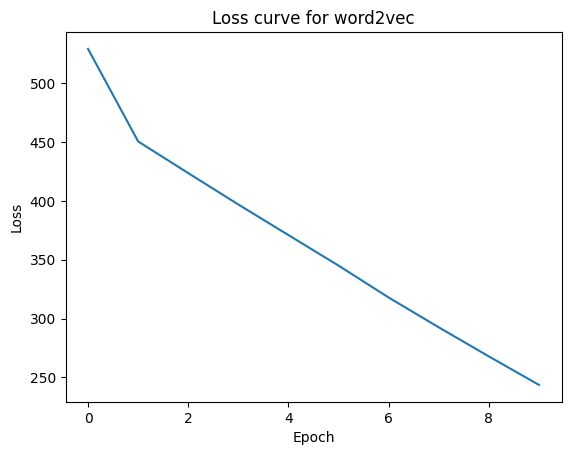

In [125]:
losses = w2v_model.fit(context_words,
                       target_words,
                       num_epochs=10)

# Plot the loss curves
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for word2vec")
plt.show()

### Cosine Similarity

Hopefully you were able to implement and train the model successfully!

Now to actually examine the embeddings you've trained. We will do one small exercise involving checking the similarity of pairs of words in the vocabulary.

This means you will need to implement the Cosine Similarity function. Recall that the Cosine Similarity between two vectors $u$ and $v$ is given by:
$$ \text{Cosine Similarity}(u, v) = \frac{u \cdot v}{||u|| \cdot ||v||} $$

You will implement this in the `cosine_similarity` function below. You will then use this function on a series of predefined word pairs to see how similar they are in the embedding space: this entails that they showed up in similar contexts in the text.

Since most people are not cultured enough to have read the Lord of the Rings, here are some notes to make sense of what you _should_ see:

- `Frodo` and `Sam` are best friends, so they should have a high similarity.

- `Gandalf` has been referred to as Gandalf the `White`.

- `Frodo` must make an arduous journey to `Mordor`.

- `Aragorn` is close to Frodo, but hasn't been to his home of the `Shire`.

In [126]:
def cosine_similarity(u, v):
    '''
    Implements the cosine similarity for vectors u and v
    '''
    ## Your code here
    sim = np.dot(u,v) / (np.linalg.norm(u)*np.linalg.norm(v))
    ## --
    return sim

print(cosine_similarity(
    w2v_model.W[dataset.stoi["frodo"]],
    w2v_model.C[dataset.stoi["sam"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["gandalf"]],
    w2v_model.C[dataset.stoi["white"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["mordor"]],
    w2v_model.C[dataset.stoi["frodo"]]
))

print(cosine_similarity(
    w2v_model.W[dataset.stoi["shire"]],
    w2v_model.C[dataset.stoi["aragorn"]]
))

0.6767389600529692
0.650194816237226
-0.07968124496990656
-0.014585922664446542


## Part 2 - Learning Embeddings with Neural Networks [50 points]

Now to spice things up.

In this part, you will frame the learning problem as a Neural Network trying to predict the center word of a window, given some _pooled_ representation of the context words. This is an updated version of the `word2vec` algorithm, only coming out the year after the original 2013 paper.

You will create a Neural Network to do this task, with the following setup:

- The model will take in a matrix of size `(batch_size, vocab_size)` representing the context words' pooled representation. We will define how this pooling is done later.

- The model will output a matrix of size `(batch_size, vocab_size)` representing the probability distribution over the vocabulary.

- The model will have one hidden layer of size `emb_dim`. This means that there are two weight matrices (and bias vectors) to be learned - these will form the Embeddings for our tokens.

- The same dataset as before will be used, so we will use the `get_windows` function in the cell below.

In [127]:
# Import in the libraries
# Note: you are NOT allowed to use any other libraries or functions outside of these

import os
import re
from typing import List, Union

import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [128]:
# Ready the dataset again
context_words, target_words = get_windows(
    dataset.tokens[:2000], 
    ctx_size=3
)

# Encode the entirety of the context words
encode = lambda x: [dataset.stoi[c] for c in x] if isinstance(x, list) else dataset.stoi[x]
context_words = [encode(cw) for cw in context_words]

### Creating our Dataset

Again, the input will be a pooled representation of the context words. When we batch multiple windows together, the input matrix will be of size `(batch_size, vocab_size)`.

First, we will represent each individual _word_ as a One-Hot Vector (since we're learning Embeddings, we have nothing better, in this situation). 

Now, for each window, suppose you have $C$ context words, and one target word. This means if you stack up all your context words' One-Hot representations, you will have a `(C, vocab_size)` matrix.

We can pool these by simply taking the mean along the first axis, such that the result would be a single vector of length `vocab_size`.

---

This operation would look like the following (suppose the `vocab_size` is 5 for this example, and we have 4 context words):

1. Stack up the One-Hot Vectors:
```python
    [
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0]
    ]
```

2. Take the mean along the first axis to get your pooled representation for a single window:
```python
    [0.25, 0.25, 0  , 0.5 , 0]
```

3. The result of step 2 will be an input to the Neural Network. You can batch together multiple of these windows to get a matrix of `(batch_size, vocab_size)`.

--- 

In the cell below, you will define

- A function to `one_hot_encode` a single vector. This is as simple as filling in a vector of `vocab_size` zeros with a one at some index.

- A function to do the following operation: `context_words_to_vector` will stack the input context words and take the mean in the fashion described above.

In [129]:
x = context_words[0]
y = encode(target_words[0])
vocab_size = dataset.vocab_size

def one_hot_encode(idx, vocab_size):
    ## Your code here
        
    one_hot_vec = np.zeros(vocab_size)
    one_hot_vec[idx] = 1
    return one_hot_vec


def context_words_to_vector(context, vocab_size):
    ## Your code here
        
    one_hot_context = np.array([one_hot_encode(word_idx, vocab_size) for word_idx in context])
    # print(one_hot_context)
    # Take the mean along the first axis
    pooled_representation = np.mean(one_hot_context, axis=0)
    return pooled_representation

X = np.array([context_words_to_vector(cw, vocab_size) for cw in context_words])

# The targets will be the indices of the target words, so this is just a vector
y = np.array([encode(t) for t in target_words])

# You can verify the correctness by looking at the shapes (or by running the test example in the markdown above)
X.shape, y.shape

((1994, 8768), (1994,))

### Creating our Neural Language Model

Now, you will create your model to do the objective mentioned before.

Since this is a Multiclass Classification objective, i.e. the model will be predicting the probability distribution of the target word over the vocab, you will have to use the Softmax function.

Your objective here is to complete the implementation of the `NeuralLM` class defined below.

Note that since we have a single hidden layer (which should use the `tanh` activation function), the first weight matrix will be of shape `(vocab_size, emb_dim)` and the second will be of shape `(emb_dim, vocab_size)`. We will use these two weight matrices to represent our Embedding matrix, since all we need is a vector of size `emb_dim` for each token in the vocab :)

Your forward pass will look like the following:

$$Z = X W^{[1]} + b^{[1]}$$
$$A = \tanh(Z)$$
$$\hat Y = A W^{[2]} + b^{[2]}$$


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>The derivative of tanh(z) is 1 - tanh(z)**2</li>
    <li>You might find it helpful to reference the tutorial notebook for Neural Networks on LMS.</li>
</ul>
</p>

In [130]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1, keepdims=True)
   
class NeuralLM:

    def __init__(self, vocab_size, emb_dim):
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.W1 = np.random.randn(vocab_size, emb_dim)
        self.b1 = np.zeros(emb_dim)
        self.W2 = np.random.randn(emb_dim, vocab_size)
        self.b2 = np.zeros(vocab_size)

        # Caching the activations and the gradients can make things very convenient
        self.activations = {}
        self.gradients = {}

    def forward(self, x):
        '''
        Performs the forward pass for our Neural Net
        '''
        ## Your code here
        h = np.dot(x, self.W1) + self.b1  # hidden layer activation
        h_z = np.tanh(h)
        yhat = np.dot(h_z, self.W2) + self.b2
        
        self.activations['z'] = h
        self.activations['h'] = h_z
        self.activations['yhat'] = (yhat)
        
        return  (yhat)
    
    def backward(self, x, y):
        '''
        Performs the backward pass for our Neural Net, computing the gradients required for updates
        '''
        yhat = self.activations['yhat']
        y_onehot = np.zeros_like(yhat)
        y_onehot[np.arange(len(yhat)), y] = 1
        grad_yhat = (softmax(yhat) - y_onehot) / len(y)

        # Gradient of the loss w.r.t output layer's weights and biases
        self.gradients['W2'] = np.dot(self.activations['h'].T, grad_yhat)
        self.gradients['b2'] = np.sum(grad_yhat, axis=0)

        # Gradient backpropagated to the hidden layer
        grad_hidden = np.dot(grad_yhat, self.W2.T) * (1 - self.activations['h'] ** 2)

        # Gradient of the loss w.r.t hidden layer's weights and biases
        self.gradients['W1'] = np.dot(x.T, grad_hidden)
        self.gradients['b1'] = np.sum(grad_hidden, axis=0)
        
     

      

    def update(self, lr):
        '''
        Updates the parameters, according to the Gradient Descent algorithm
        '''
        ## Your code here
        self.W1 -= lr * self.gradients['W1']
        self.b1 -= lr * self.gradients['b1']
        self.W2 -= lr * self.gradients['W2']
        self.b2 -= lr * self.gradients['b2']
        ## --

    def fit(self, x, y, epochs=10, lr=0.01):
        '''
        Runs the entire training loop for the specific number of epochs
        '''
        
        losses = []

        for epoch in range(epochs):
            yhat = self.forward(x)
            self.backward(x, y)
            self.update(lr)
            
            # Compute loss
            logprobas = np.log(softmax(yhat))
            loss = -logprobas[range(len(yhat)), y].mean()
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")

            losses.append(loss)

        return losses

### Training our model and getting the Embeddings

Run the cell below to train your model, and plot the loss curves.

Epoch 1/50 - Loss: 16.0165
Epoch 2/50 - Loss: 15.9898
Epoch 3/50 - Loss: 15.9633
Epoch 4/50 - Loss: 15.9371
Epoch 5/50 - Loss: 15.9111
Epoch 6/50 - Loss: 15.8853
Epoch 7/50 - Loss: 15.8597
Epoch 8/50 - Loss: 15.8344
Epoch 9/50 - Loss: 15.8093
Epoch 10/50 - Loss: 15.7844
Epoch 11/50 - Loss: 15.7598
Epoch 12/50 - Loss: 15.7353
Epoch 13/50 - Loss: 15.7111
Epoch 14/50 - Loss: 15.6871
Epoch 15/50 - Loss: 15.6632
Epoch 16/50 - Loss: 15.6396
Epoch 17/50 - Loss: 15.6162
Epoch 18/50 - Loss: 15.5930
Epoch 19/50 - Loss: 15.5700
Epoch 20/50 - Loss: 15.5472
Epoch 21/50 - Loss: 15.5246
Epoch 22/50 - Loss: 15.5022
Epoch 23/50 - Loss: 15.4799
Epoch 24/50 - Loss: 15.4579
Epoch 25/50 - Loss: 15.4360
Epoch 26/50 - Loss: 15.4144
Epoch 27/50 - Loss: 15.3929
Epoch 28/50 - Loss: 15.3715
Epoch 29/50 - Loss: 15.3504
Epoch 30/50 - Loss: 15.3294
Epoch 31/50 - Loss: 15.3087
Epoch 32/50 - Loss: 15.2880
Epoch 33/50 - Loss: 15.2676
Epoch 34/50 - Loss: 15.2473
Epoch 35/50 - Loss: 15.2272
Epoch 36/50 - Loss: 15.2073
E

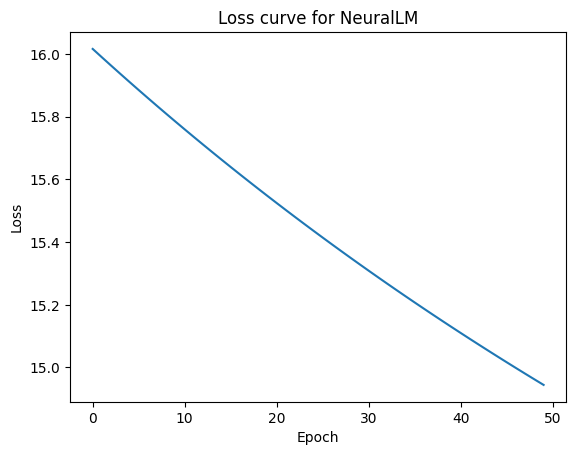

In [131]:
model = NeuralLM(vocab_size, emb_dim=100)
losses = model.fit(X, y, epochs=50, lr=0.01)


# Plot the loss curves from 50
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curve for NeuralLM")
plt.show()

Now that you've hopefully seen the model improving, we can extract its weight matrices to use as the Embeddings.

We have the choice of using either one, or we could do something really funny and take the average of both.

In [132]:
# Get the embeddings from the model
embedding_matrix = (model.W1 + model.W2.T) / 2

print(cosine_similarity(
    embedding_matrix[dataset.stoi["frodo"]],
    embedding_matrix[dataset.stoi["sam"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["gandalf"]],
    embedding_matrix[dataset.stoi["white"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["mordor"]],
    embedding_matrix[dataset.stoi["frodo"]]
))

print(cosine_similarity(
    embedding_matrix[dataset.stoi["shire"]],
    embedding_matrix[dataset.stoi["aragorn"]]
))

-0.0590895129124689
-0.0006642757588904374
-0.021610355759632847
-0.07004724345354418


Think about whether these performed better than the previous ones, and why.

## Part 3 - Playing with Word Vectors [20 points]

The intensive parts of this assignment are over - now we'll play with pretrained embeddings, i.e. embeddings that someone else has trained.

We will use the GloVe embeddings from `gensim`, a Python library made for interacting with word vectors.

In the cells below, we will make our imports, load in our embeddings, and construct our numpy matrix.

In [133]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api
from pprint import pprint

def load_embedding_model():
    '''
    Loads the GloVe embeddings from gensim
    '''
    gensim_wv = api.load("glove-wiki-gigaword-200")
    print(f"Loaded embeddings with vocab size {len(gensim_wv.key_to_index)} with vector size {gensim_wv.vector_size}")
    return gensim_wv

In [134]:
# Load in the Embeddings (this can take ~8 minutes)
gensim_wv = load_embedding_model()

Loaded embeddings with vocab size 400000 with vector size 200


In [135]:
def get_embedding_matrix(gensim_wv):
    
    # Get the words in the vocab
    words = list(gensim_wv.index_to_key)
    stoi = {}
    M = []
    curInd = 0
    
    # Add the words to the matrix M
    for w in words:
        try:
            M.append(gensim_wv.get_vector(w))
            stoi[w] = curInd
            curInd += 1
        except KeyError:
            continue
    
    # Convert the list of vectors to a numpy matrix
    M = np.stack(M)
    print("Done.")

    return M, stoi

M, stoi = get_embedding_matrix(gensim_wv)
print(f"Shape of the embedding matrix: {M.shape}")

Done.
Shape of the embedding matrix: (400000, 200)


### Visualizing our embeddings

Now that we've created our matrix, let's work on visualizing them.

The issue with these embeddings is that they are in 200 dimensions. Most humans can't see beyond 3 dimensions, and it's convenient to plot in 2.

One nifty trick we can do to _squish_ down a vector in higher dimensions, to something in fewer dimensions, is to utilize **Dimensionality Reduction** techniques. This will learn the ambient structure in the data, and use it to capture as much information (technically, the "variance") in the amount of dimensions you want.

Most people go with [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for this. We will go with a variant of [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition), a method to factorize a matrix.

You can read up on the documentation for the `sklearn` implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In the cell below, implement the `reduce_to_k_dim` algorithm, where you run `TruncatedSVD` to squish your `(vocab_size, emb_dim)` matrix to `(vocab_size, K)`, where `K` is much smaller than `emb_dim`.

In [136]:
def reduce_to_k_dim(M, k=2):
    '''
    Reduce a matrix of shape (num_words, num_dim) to (num_words, k) dimensions
    '''
    n_iters = 10
    print(f"Running Truncated SVD over {n_iters} iterations...")

    ## Your code here
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)    
    ## --

    return M_reduced

# Reduce the matrix to 2 dimensions
M_reduced = reduce_to_k_dim(M, k=2)

# Normalize the rows to make them of unit length (helps with visualization)
M_reduced_unit = M_reduced / np.linalg.norm(M_reduced, axis=1, keepdims=True)

print(f"Shape of the reduced matrix: {M_reduced_unit.shape}")

Running Truncated SVD over 10 iterations...
Shape of the reduced matrix: (400000, 2)


In the cell below, you can plot out the embeddings from the reduced matrix. Note that since we squished the information coming from 200 dimensions into just 2, we won't have a perfect visualization by any means, but it's still worth studying.

In the cell below, you can fill `words_to_plot` with words whose embeddings you'd like to see in a scatterplot. If you wish to join pairs of words, you can pass them in as pairs in the `pairs_to_join` variable.

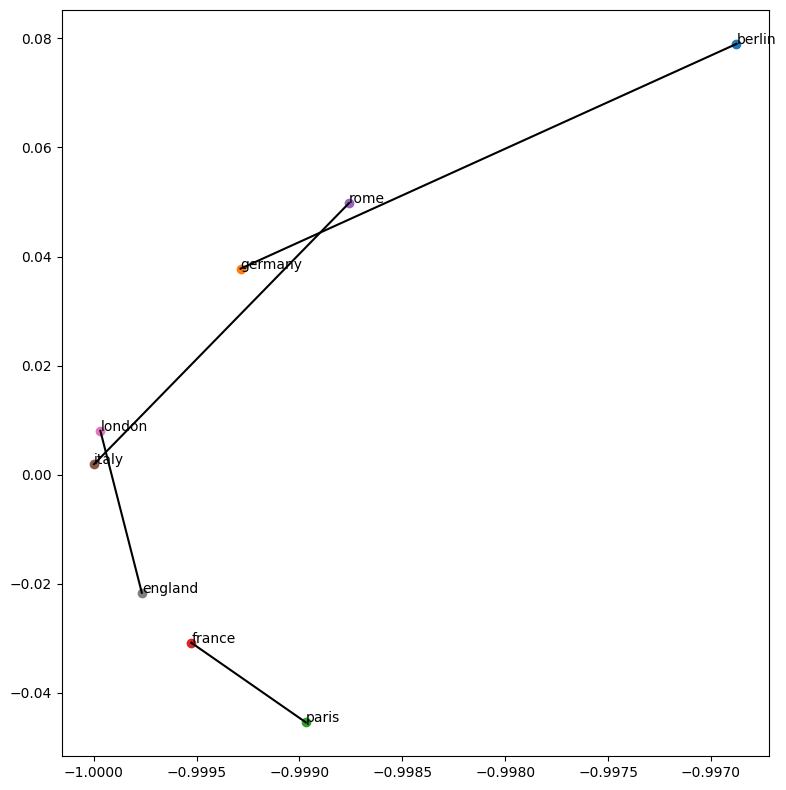

In [137]:
def plot_embeddings(M_reduced_unit, words, stoi, pairs_to_join):
    '''
    Produces a scatterplot of the embeddings with the words annotated

    Parameters:
    M_reduced_unit : np.ndarray
        The reduced matrix of embeddings
    words : List[str]
        The words to annotate
    '''
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, txt in enumerate(words):
        word_ind = stoi.get(txt)
        ax.scatter(M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1])
        ax.annotate(txt, (M_reduced_unit[word_ind, 0], M_reduced_unit[word_ind, 1]))

    for pair in pairs_to_join:
        w1, w2 = pair
        w1_ind = stoi.get(w1)
        w2_ind = stoi.get(w2)
        ax.plot([M_reduced_unit[w1_ind, 0], M_reduced_unit[w2_ind, 0]], 
                [M_reduced_unit[w1_ind, 1], M_reduced_unit[w2_ind, 1]], 'k-')

    plt.tight_layout()
    plt.show()

words_to_plot = ["berlin", "germany", "paris", "france", "rome", "italy", "london", "england"]
pairs_to_join = [("berlin", "germany"), ("paris", "france"), ("rome", "italy"), ("london", "england")]
plot_embeddings(M_reduced_unit, words_to_plot, stoi, pairs_to_join)

### Analogies with Word Vectors

Recall from the lectures that word vectors let us capture relationships between words. This means we can use vector arithmetic to create _analogies_.

For example, if we had an embedding matrix E, and we wanted to find the relationship between `king` and `man`, and `queen` and `woman`, we would find

$$E[\text{king}] - E[\text{man}] \approx E[\text{queen}] - E[\text{woman}]$$

`gensim` makes this really easy for us. To save time, we can use the `most_similar` function to capture the nearest neighbors to the vector you get when "constructing the parallelogram" (from lecture).

In [138]:
# "king is to man, as ??? is to woman"
gensim_wv.most_similar(
    positive=['woman', 'king'],
    negative=['man']
)

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]

These are not perfect by any means. Run the cell below to see one case of the arithmetic failing.

Write a few words about why this might be the case - there's a very reasonable explanation, provided you don't use the metric system ;)

In [139]:
# "glove is to hand as ??? is to foot"
gensim_wv.most_similar(
    positive=['foot', 'glove'],
    negative=['hand']
)

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]

<div style="color: green"> Write your answer here. </div>
 The word embedding might be picking up on this other meaning of ‘foot’, leading to results that are related to measurements rather than body parts. Another possibility is that there simply isn’t a common word for a ‘foot glove’ in the same way there is for a hand (i.e., a glove), and so the model struggles to find a suitable analogy.

Lastly, it's important to know that biases and stigmas are implicit inside these word embeddings. 

Run the cell below, to examine (a) which terms are most similar to "woman" and "profession" and most dissimilar to "man", and (b) which terms are most similar to "man" and "profession" and most dissimilar to "woman". 

Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [140]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint(gensim_wv.most_similar(positive=['man', 'profession'], negative=['woman']))
print('-'*25)
pprint(gensim_wv.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]
-------------------------
[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


<div style="color: green"> Write your answer here. </div>

If the training data used to train gensim embeddings, frequently associates men with professions and women with domestic roles, the word embedding model might learn to associate “man” with words related to professions and “woman” with words related to domestic roles. This  reflects  gender bias in the training data

# Fin.